In [1]:
import random
import math
import warnings
import pandas as pd
from utils import EnhancerDataset, split_dataset, train_model, regression_model_plot, plot_filter_weight
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import sys
import interpretation
import numpy as np
import torch
import tools
import logomaker
sys.path.append('../model')  
from model import ExplaiNN3

In [2]:

def generate_random_dna(length, num_dna, motifA, motifB, directionality_is_true):
    """Generate random DNA sequences and calculate the motif distance score."""
    if (len(motifA) + len(motifB)) > (length - 10):
        raise ValueError('Length of motif A plus motif B greater then dna length minus 10')
    if len(motifA) > length // 3 or len(motifB) > length // 3:
        warnings.warn("One of the motifs is longer than one-third of the DNA length.")
    
    dna_sequences = []
    scores = []
    proportion = {'no_A_no_B': 0, 'no_A_has_B': 0, 'has_A_no_B':0, 'has_A_has_B':0, 'A_before_B': 0, 'B_before_A': 0}
    
    nucleotides = ['A', 'T', 'C', 'G']
    
    for _ in range(num_dna):
        # Generate a random DNA sequence
        dna = ''.join(random.choices(nucleotides, k=length))
        
        # Decide randomly whether to insert motifA and motifB
        insert_motifA = random.choice([True, False])
        insert_motifB = random.choice([True, False])

        index_a = -1
        index_b = -1
        
        if insert_motifA:
            # Pick a random portion of dna to get replaced by motifA
            index_a = random.randint(0, length - len(motifA))
            dna = dna[:index_a] + motifA + dna[index_a + len(motifA):]
        
        if insert_motifB:
            not_inserted_yet = True
            while not_inserted_yet:
                index_b = random.randint(0, length - len(motifB))
                # Check if the selected index b would cause motifB overlap motifA
                if (index_b + len(motifB) <= index_a) or (index_a + len(motifA) <= index_b):
                    dna = dna[:index_b] + motifB + dna[index_b + len(motifB):]
                    not_inserted_yet = False
        
        dna_sequences.append(dna)

        if insert_motifA and insert_motifB:
            proportion['has_A_has_B'] += 1
            if index_a < index_b:
                proportion['A_before_B'] += 1
            elif index_a > index_b:
                proportion['B_before_A'] += 1
        elif insert_motifA and not insert_motifB:
            proportion['has_A_no_B'] += 1
        elif not insert_motifA and insert_motifB:
            proportion['no_A_has_B'] += 1
        elif not insert_motifA and not insert_motifB:
            proportion['no_A_no_B'] += 1
        
        # Calculate the motif distance score
        motifs_a = list(find_all_motifs(dna, motifA)) if insert_motifA else []
        motifs_b = list(find_all_motifs(dna, motifB)) if insert_motifB else []
        
        score = 0
        if motifs_a and motifs_b:
            for (start_a, end_a) in motifs_a:
                for (start_b, end_b) in motifs_b:
                    if end_a <= start_b:
                        distance = start_b - end_a
                    elif end_b <= start_a:
                        distance = start_a - end_b
                    else:
                        overlap_start = max(start_a, start_b)
                        overlap_end = min(end_a, end_b)
                        overlap_length = overlap_end - overlap_start
                        longer_motif_length = max(end_a - start_a, end_b - start_b)
                        distance = overlap_length / longer_motif_length
                    if distance < float('inf'):
                        if distance >= 1:
                            score = math.exp(1 / (distance))
                        elif distance == 0:
                            score = math.exp(1 / (0.8))
                        else:
                            raise ValueError("distance between motifA and motifB cannot be negative")
                    
                    if directionality_is_true and start_b < start_a:
                        score = 0
            
        scores.append(score) 
    return dna_sequences, scores, proportion

def find_all_motifs(sequence, motif):
    """Find all occurrences of a motif in the sequence, returning start and end positions."""
    start = 0
    motif_length = len(motif)
    while True:
        start = sequence.find(motif, start)
        if start == -1:
            break
        end = start + motif_length
        yield (start, end)
        start += 1  # Move start forward for next search to allow overlapping motifs

# Example usage
dna_sequences, scores, portions = generate_random_dna(length=608, num_dna=30000, motifA='CCTTAAGGAGAGTCTCTTT', motifB='CAAGGAGTTCTTACGGAGC', directionality_is_true=True)
print(portions)


{'no_A_no_B': 7537, 'no_A_has_B': 7536, 'has_A_no_B': 7348, 'has_A_has_B': 7579, 'A_before_B': 3730, 'B_before_A': 3849}


In [3]:
# Define some hyperparameters
seed = 42
batch = 300
num_cnns = 90
learning_rate = 1e-4
target_labels = ['Motif Distance Score']
feature_lis = ['score']
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/ExplaiNN_synthetic_motif_dir_results'


#df = pd.DataFrame({'sequence':dna_sequences, 'score': scores})
df = pd.read_csv("/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/synthetic_sequence_dir.csv")
# Plot histogram of scores
#plt.hist(df['score'], bins=100, edgecolor='black')
#plt.title('Distribution of Scores')
#plt.xlabel('Score')
#plt.ylabel('Frequency')
#plt.ylim(0,300)
#plt.show()

train, test = split_dataset(df, split_type='random', cutoff = 0.8, seed = seed)

train = EnhancerDataset(train, feature_list=feature_lis, scale_mode = 'none')
test = EnhancerDataset(test, feature_list=feature_lis, scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=True)

input_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 1, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, device  = train_model(input_model, train_loader, test_loader, 
                                                                                                                            target_labels=target_labels,num_epochs=200, 
                                                                                                                        batch_size=batch, learning_rate=learning_rate, 
                                                                                                                        criteria='mse',optimizer_type = "adam", patience=10, 
                                                                                                                        seed = seed, save_model= True, dir_path=output_dir)

Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/80, Loss: 0.5847
Epoch 1/200: Train Loss: 0.4180 , Test Loss: 0.2213
------------------------Evaluation------------------------
Label 1: MSE=0.2213, RMSE=0.4704, MAE=0.3784, R^2=-0.8362, Pearson=0.0191, Spearman=0.0243
Overall (Flattened): MSE=0.2213, RMSE=0.4704, MAE=0.3784, R^2=-0.8362, Pearson=0.0191, Spearman=0.0243
----------------------------------------------------------
Epoch 2/200, Step 1/80, Loss: 0.3012
Epoch 2/200: Train Loss: 0.2643 , Test Loss: 0.1919
------------------------Evaluation------------------------
Label 1: MSE=0.1919, RMSE=0.4381, MAE=0.3264, R^2=-0.5923, Pearson=0.0328, Spearman=0.0382
Overall (Flattened): MSE=0.1919, RMSE=0.4381, MAE=0.3264, R^2=-0.5923, Pearson=0.0328, Spearman=0.0382
----------------------------------------------------------
Epoch 3/200, Step 1/80, Loss: 0.1944
Epoch 3/200: Train Loss: 0.2179 , Test Loss: 0.1860
------------------------Evaluation------------------------
Labe

In [17]:
best_r2_epoch

37

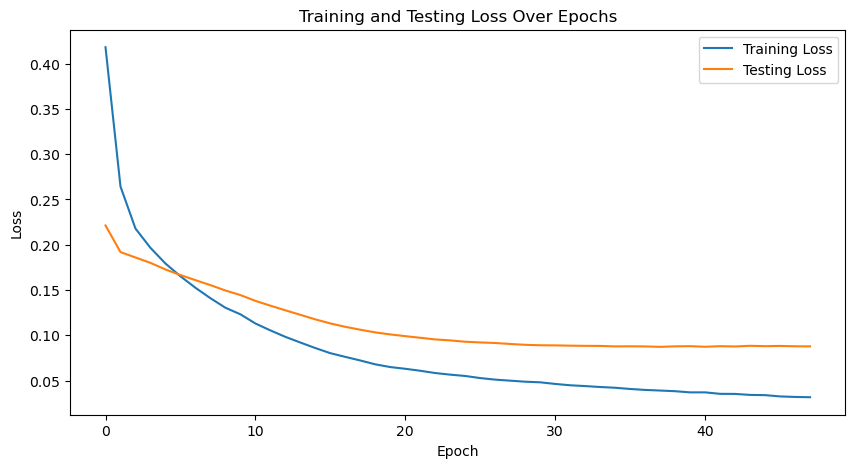

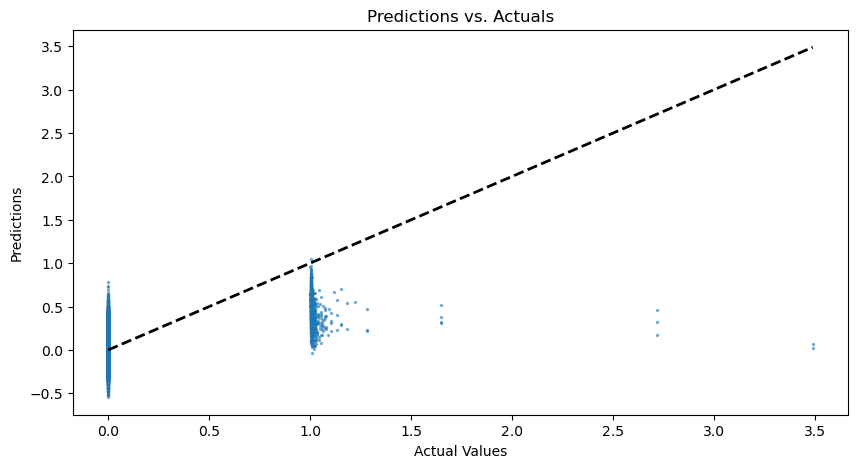

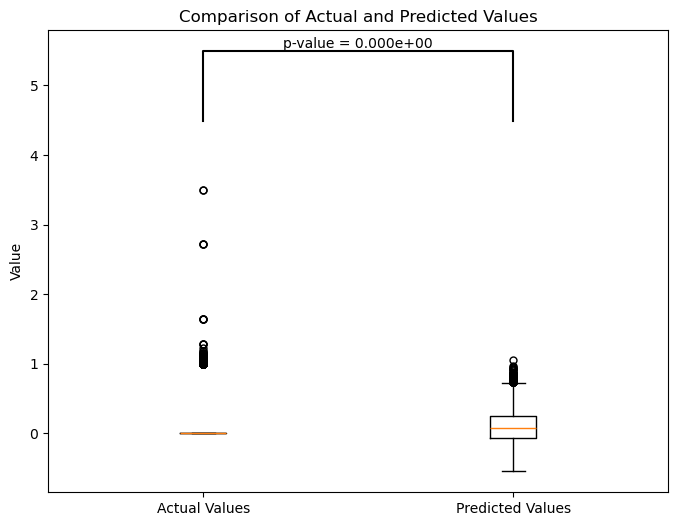

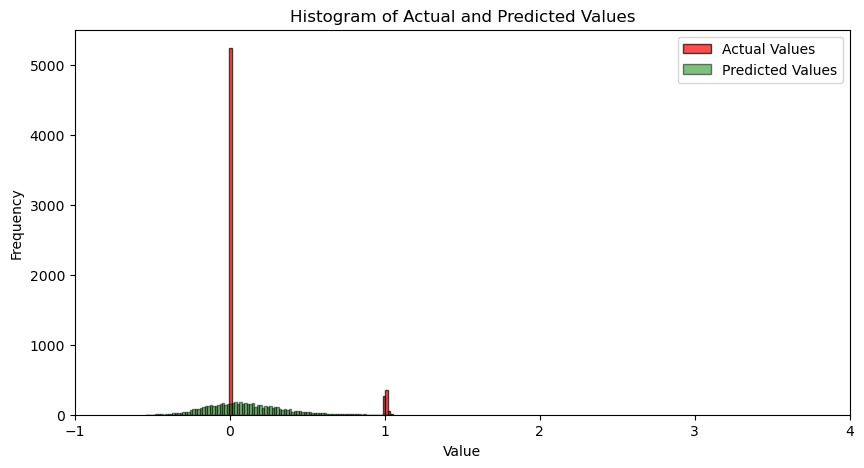

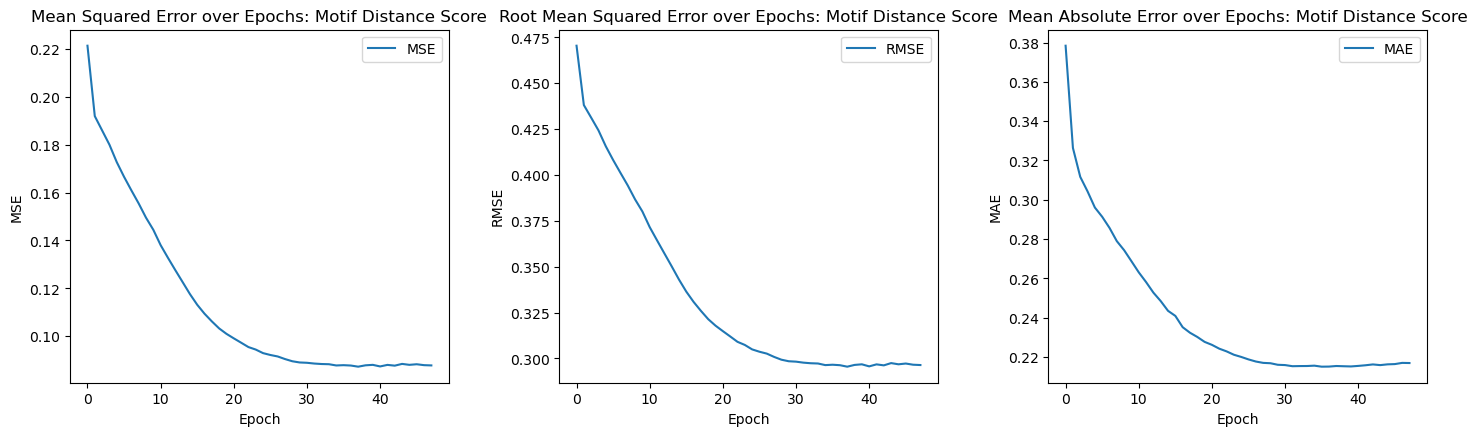

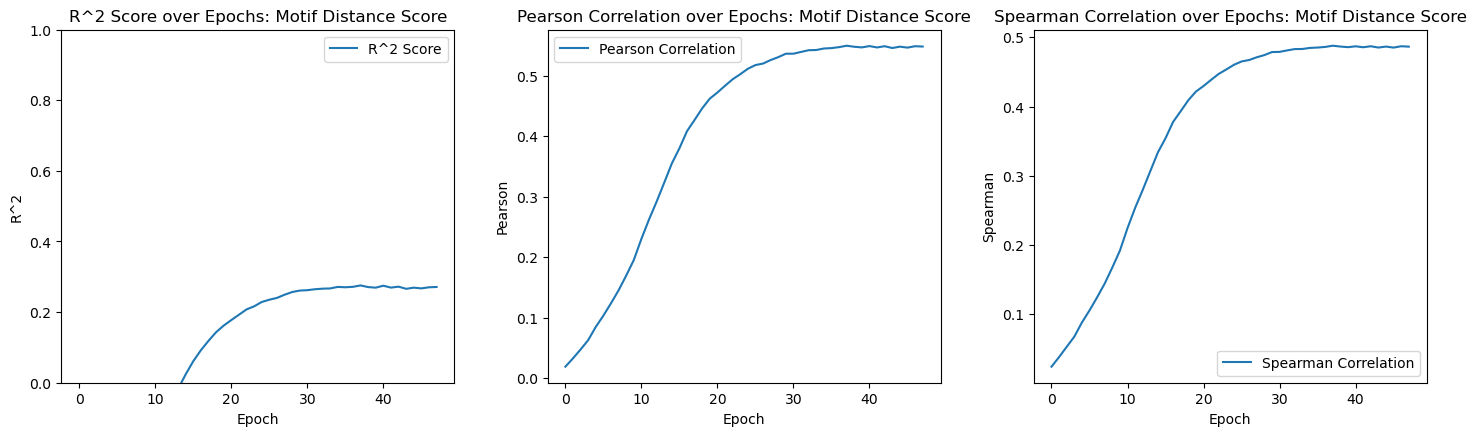

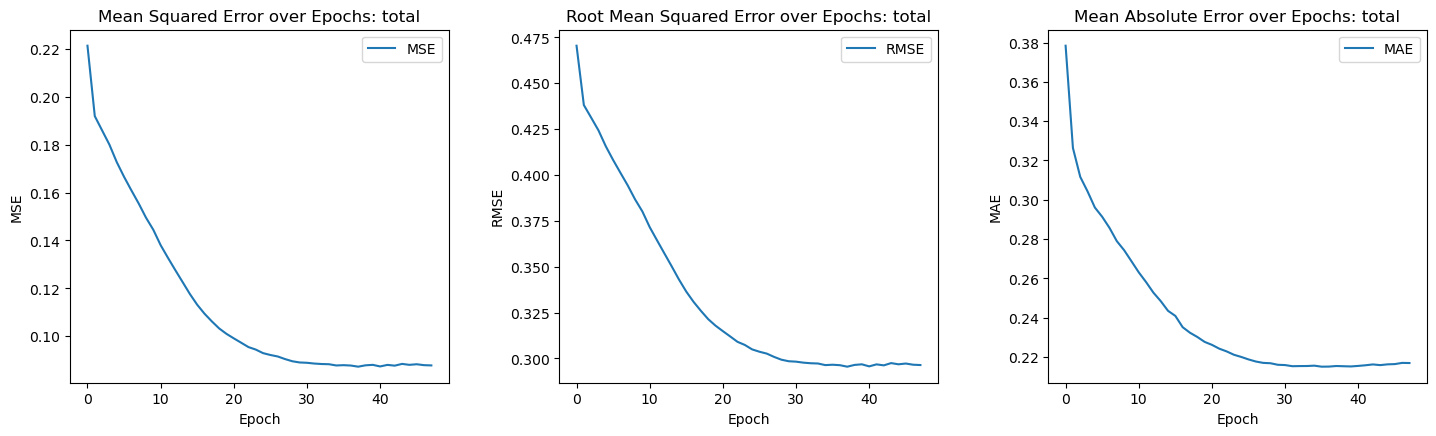

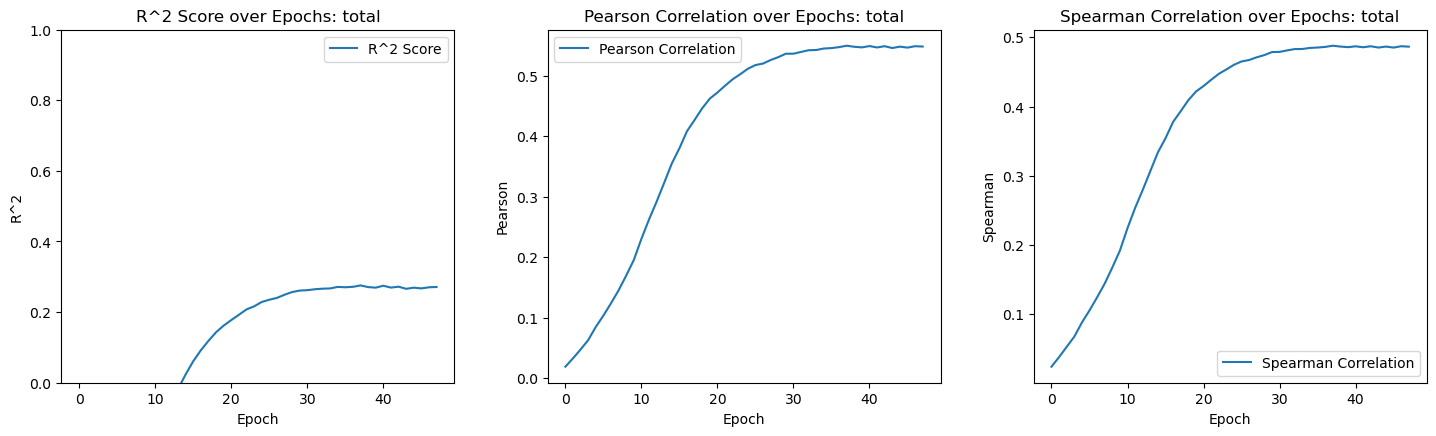

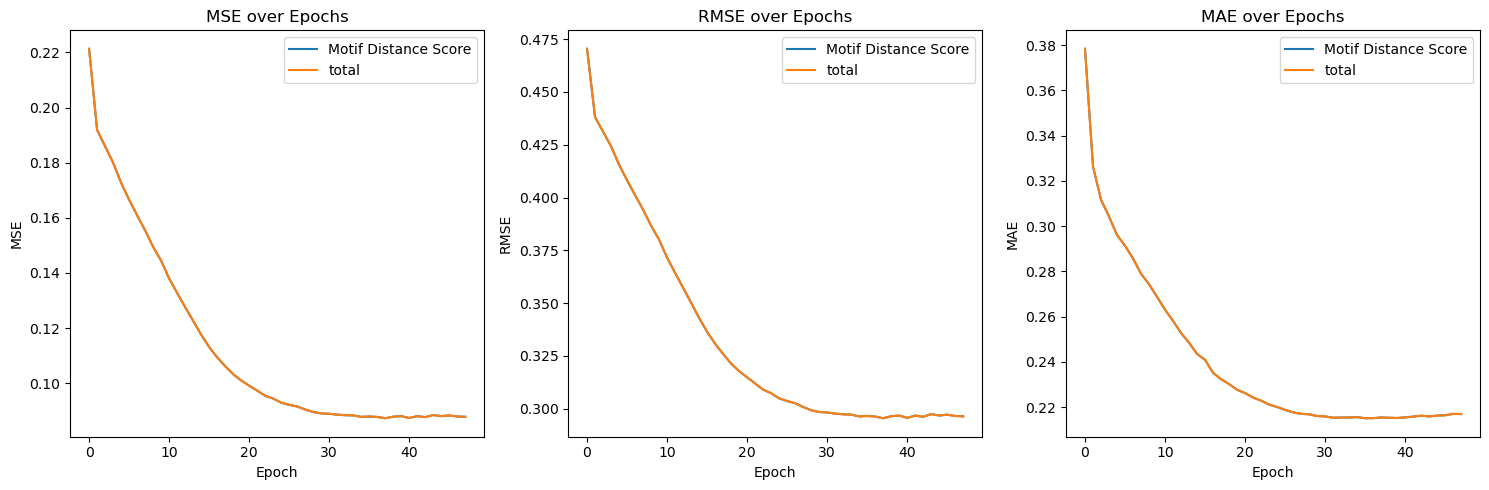

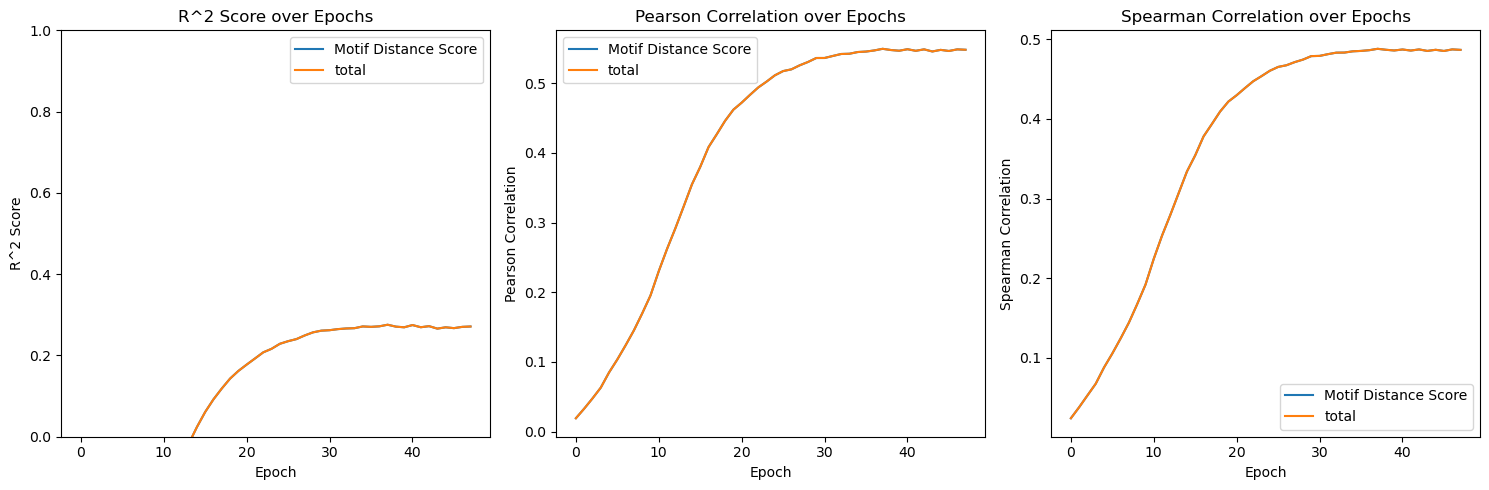

MSE: 0.0878, RMSE: 0.2964, MAE: 0.2169
R^2: 0.2712, Pearson Correlation: 0.5482, Spearman Correlation: 0.4865


In [16]:
#best_r2_epoch = 37
model_path = f'/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/ExplaiNN_synthetic_motif_dir_results/model_epoch_{best_r2_epoch}.pth'

mse, rmse, mae, r2, pearson_corr, spearman_corr = regression_model_plot(
    model, test_loader, train_losses_by_batch, test_losses_by_batch, 
    device, results, label_mode = "score", save_plot = False, dir_path = None, model_path = model_path, best_model=best_r2_epoch)

print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}, Pearson Correlation: {pearson_corr:.4f}, Spearman Correlation: {spearman_corr:.4f}")

# Interpretation

In [2]:
filter_size = 19
num_cnns = 90
filter_size = 19
best_r2_epoch = 21
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
explainn = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 1, 
                 filter_size = filter_size, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training
explainn.to(device)  

weight_file = f'/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/ExplaiNN_synthetic_motif_dir_results/model_epoch_{best_r2_epoch}.pth'
explainn.load_state_dict(torch.load(weight_file))
explainn.eval()

ExplaiNN3(
  (linears): Sequential(
    (0): Conv1d(360, 90, kernel_size=(19,), stride=(1,), groups=90)
    (1): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ExpActivation()
    (3): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Unsqueeze()
    (6): Conv1d(7560, 9000, kernel_size=(1,), stride=(1,), groups=90)
    (7): BatchNorm1d(9000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(9000, 90, kernel_size=(1,), stride=(1,), groups=90)
    (11): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (final): Linear(in_features=90, out_features=1, bias=True)
)

In [3]:
batch = 300
df = pd.read_csv("/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/synthetic_sequence_dir.csv")

dataset = EnhancerDataset(df, label_mode='score', scale_mode = 'none')
# Prepare dataloader
dataset = DataLoader(dataset=dataset, batch_size=batch, shuffle=False)

# Running get_explainn_predictions function to get predictions and true labels for all sequences in the given data loader
predictions, labels = interpretation.get_explainn_predictions(dataset, explainn, device, isSigmoid=False)
print(predictions.shape)

(30000, 1)


Number of samples before filtering: 30000
torch.Size([2842, 4, 608])
torch.Size([2842, 1])
Number of samples after filtering: 2842


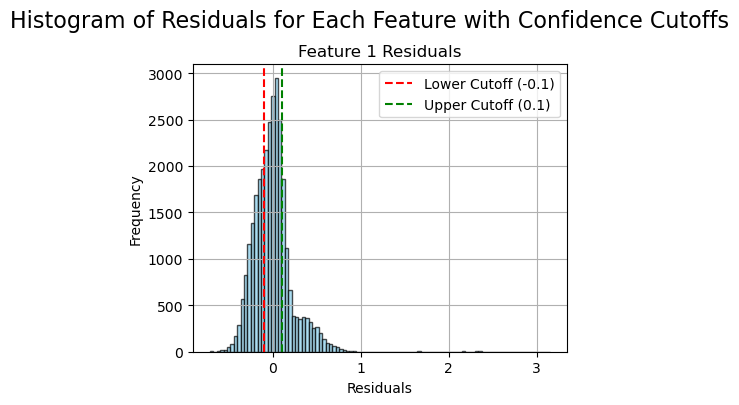

In [4]:
# Prepare features and labels:
# --(Features): Transform all sequences into one-hot encodings
# --(Labels): Use GFP+ and GFP- as labels
dataset = EnhancerDataset(df, label_mode='score', scale_mode = 'none')
# Prepare dataloader
dataset = DataLoader(dataset=dataset, batch_size=batch, shuffle=False)

# Running get_explainn_predictions function to get predictions and true labels for all sequences in the given data loader
predictions, labels = interpretation.get_explainn_predictions(dataset, explainn, device, isSigmoid=False)

"""Now filter out low confident predictions"""
# Calculate absolute residuals
residuals = np.abs(labels - predictions)

# Define the upper bound of residuals
upper_bound = 0.02

# Create a mask for filtering out samples with low confident precition (abs(residual) > upper_bound)
mask = (residuals <= upper_bound).all(axis=1)

# Get sequences and labels from dataset
data_inp = []
data_out = []
# Iterate over the DataLoader
for batch_features, batch_labels in dataset:
    data_inp.append(batch_features)
    data_out.append(batch_labels)
# Concatenate all the batches into single tensors
data_inp = torch.cat(data_inp, dim=0)
data_out = torch.cat(data_out, dim=0)

# Use the mask to filter the predictions and labels
print(f'Number of samples before filtering: {len(data_inp)}')
data_inp = data_inp[mask]
data_out = data_out[mask]
print(data_inp.shape)
print(data_out.shape)

print(f'Number of samples after filtering: {len(data_inp)}')

# Create new dataloader with filtered high confident samples
dataset = torch.utils.data.TensorDataset(data_inp, data_out)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch, shuffle=False,)

# Plot histogram of residuals with adjusted cutoff lines
# 1. Compute residuals (not absolute)
residuals = labels - predictions

# 2. Define bounds for plotting
upper_bound = 0.1
lower_bound = -0.1

# 3.Plotting the histograms for each feature
fig, axes = plt.subplots(nrows=predictions.shape[1], ncols=1, figsize=(5, 4*predictions.shape[1]))
fig.tight_layout(pad=3.0)

# Title for the entire figure
fig.suptitle('Histogram of Residuals for Each Feature with Confidence Cutoffs', fontsize=16, y=1.02)

# Ensure axes is a list even if there's only one subplot
if predictions.shape[1] == 1:
    axes = [axes]

for i in range(predictions.shape[1]):
    ax = axes[i]
    ax.hist(residuals[:, i], bins=100, color='skyblue', edgecolor='black', alpha=0.7)
    ax.axvline(x=lower_bound, color='red', linestyle='--', label=f'Lower Cutoff ({lower_bound})')
    ax.axvline(x=upper_bound, color='green', linestyle='--', label=f'Upper Cutoff ({upper_bound})')
    ax.set_title(f'Feature {i+1} Residuals')
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True)

plt.show()

In [27]:
""" ！！！！！！！！！！！！
You don't need to run this if you already calculated activations and pwms before
"""
# Get weights from activation layer
activations = interpretation.get_explainn_unit_activations(data_loader, explainn, device)
print(f"Activations have shape: {activations.shape}")
# Save activations
activation_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/90CNN_synthetic_score_dir_Activations.npy'
np.save(activation_path, activations)

# Get torch,  one-hot encoding sequences from data_loader
sequences = []
# Iterate over the DataLoader
for batch in data_loader:
    batch_sequences = batch[0]  
    sequences.append(batch_sequences)
sequences = torch.cat(sequences, dim=0)

# Define filter size. This parameter should be consistent with filter_size used in ExplaiNN
filter_size = 19
pwms = interpretation.get_pwms_explainn(activations, sequences, filter_size)

# Save pwms
pwm_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/90CNN_synthetic_score_dir_pwms.npy'
np.save(pwm_path, pwms)

100%|████████████████████| 10/10 [00:00<00:00, 16.47it/s]


Activations have shape: (2842, 90, 590)


100%|████████████████████| 90/90 [00:01<00:00, 63.27it/s]


In [5]:
pwm_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/90CNN_synthetic_score_dir_pwms.npy'
activation_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/90CNN_synthetic_score_dir_Activations.npy'
pwm_name = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/90CNN_synthetic_score_dir_TFBS.meme'
activations = np.load(activation_path)
print(f"Activations have shape: {activations.shape}")
pwms = np.load(pwm_path)
print(f"PWMs have shape: {pwms.shape}")
interpretation.pwm_to_meme(pwms, pwm_name)

Activations have shape: (2842, 90, 590)
PWMs have shape: (90, 4, 19)
Saved PWM File as : /pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_synthetic_score_dir_TFBS.meme


In [6]:
tomtom_results = pd.read_csv("/pmglocal/ty2514/Enhancer/Enhancer/tomtom_2024results/tomtom_CAM_90NN_synthetic_score_dir/tomtom.tsv",
                                        sep="\t",comment="#")
filters_with_min_q = tomtom_results.groupby('Query_ID').min()["q-value"]
tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]
cisbp_motifs = {}
with open("/pmglocal/ty2514/Enhancer/ExplaiNN/data/JASPAR/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt") as f:
    for line in f:
        if "MOTIF" in line:
            motif = line.strip().split()[-1]
            name_m = line.strip().split()[-2]
            cisbp_motifs[name_m] = motif

filters = tomtom_results["Query_ID"].unique()
annotation = {}
for f in filters:
    t = tomtom_results[tomtom_results["Query_ID"] == f]
    target_id = t["Target_ID"]

    if len(target_id) > 5:
       target_id = target_id[:5]

    ###!!!!!!!!!!!!!
    target_id = target_id[:1]  ### If you only want to keep the most significant target_id, keep this line

    # Join Unique annotations by '/'
    ann = "/".join({cisbp_motifs[i]: i for i in target_id.values})
    annotation[f] = ann

annotation = pd.Series(annotation)
annotation

filter0           CTCF
filter1           CTCF
filter4           CTCF
filter6           CTCF
filter7           CTCF
filter9           CTCF
filter10          CTCF
filter13          CTCF
filter15          CTCF
filter16          CTCF
filter19          CTCF
filter21          CTCF
filter22          CTCF
filter23          CTCF
filter24          CTCF
filter25          CTCF
filter26          CTCF
filter27          CTCF
filter28          CTCF
filter30          CTCF
filter31          CTCF
filter32          CTCF
filter33          CTCF
filter35       ZNF354A
filter36          CTCF
filter37          CTCF
filter40          CTCF
filter44          CTCF
filter46          CTCF
filter50       ZNF354A
filter51        ZNF320
filter52          CTCF
filter53          CTCF
filter54          CTCF
filter55          CTCF
filter56          CTCF
filter59          CTCF
filter60       ZNF354A
filter62          CTCF
filter63          CTCF
filter64       ZNF354A
filter65          CTCF
filter70          CTCF
filter71   

In [7]:
weights = explainn.final.weight.detach().cpu().numpy()
len(weights)

1

In [8]:
weights = explainn.final.weight.detach().cpu().numpy()
print(weights.shape)
num_cnns = 90
filters = ["filter"+str(i) for i in range(num_cnns)]
annotated_filters = ["filter"+str(i) for i in range(num_cnns)]

target_labels = ["Motif Distance Score"]

for i in annotation.keys():
    annotated_filters[int(i.split("filter")[-1])] = annotation[i]

weight_df = pd.DataFrame(weights, target_labels, columns=annotated_filters)
filters_df = pd.DataFrame([filters], index=["filters"], columns=annotated_filters)
weight_df = pd.concat([weight_df, filters_df])
weight_df.shape
weight_df

(1, 90)


,CTCF,CTCF,filter2,filter3,CTCF,filter5,CTCF,CTCF,filter8,CTCF,...,filter80,CTCF,CTCF,CTCF,filter84,CTCF,filter86,filter87,filter88,CTCF
Motif Distance Score,-0.023359,-0.028198,-0.022131,0.019675,0.0194,0.024223,0.02235,-0.025972,-0.024048,0.018925,...,0.017423,-0.020668,-0.024601,0.030987,-0.024499,-0.020082,0.033312,-0.020338,0.028225,-0.020257
filters,filter0,filter1,filter2,filter3,filter4,filter5,filter6,filter7,filter8,filter9,...,filter80,filter81,filter82,filter83,filter84,filter85,filter86,filter87,filter88,filter89


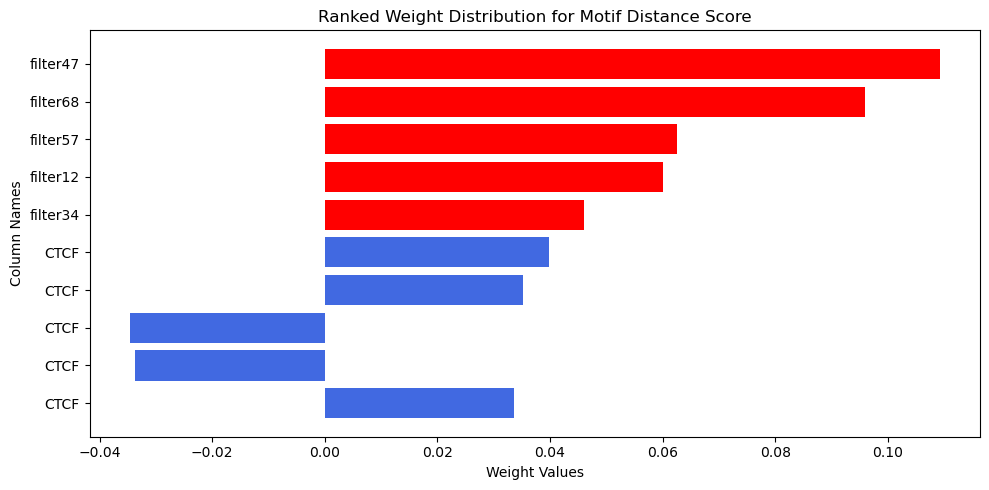

In [9]:
### Plot Bar Plots of Filter Weight Values
plot_filter_weight(weight_df, top_n=10)

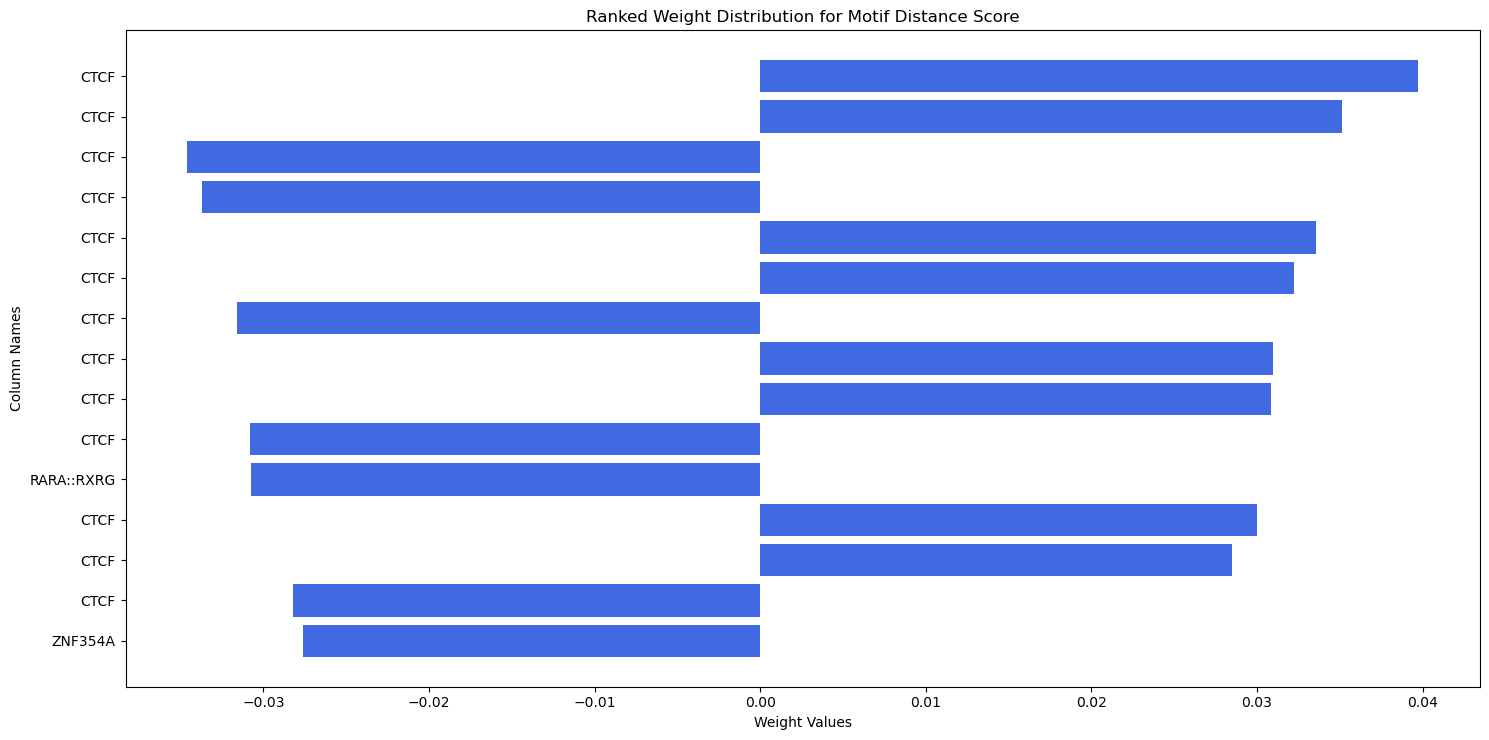

In [10]:
# Remove columns that does not have annotations
ann_wdf = weight_df.loc[:,["filter" not in i for i in list(weight_df)]]

plot_filter_weight(ann_wdf, top_n=15)

In [22]:
# Assuming 'interpretation' and 'explainn' are already defined and properly configured
# Also assuming 'data_loader', 'device', and 'annotation' are defined as per your setup

unit_importance_GFP_pos = []
unit_importance_GFP_neg = []
unit_importance_motif_dist_score = []
unit_names = []
unit_filters = []

# Loop through units with indices 0 to 4
for unit_index in range(num_cnns):
    filter_key = "filter" + str(unit_index)
    title = annotation[filter_key] if filter_key in annotation.index else filter_key
    unit_names.append(title)  # Store the unit name for plotting
    unit_filters.append(filter_key)
    
    # Calculate unit importance for the current unit
    unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, explainn, device)
    importance = interpretation.get_specific_unit_importance(activations, explainn, unit_outputs, unit_index, target_labels)
    unit_importance_motif_dist_score.append(importance['Motif Distance Score'])

In [23]:
means = [np.mean(values) for values in unit_importance_motif_dist_score]
sorted_data = sorted(zip(means, unit_names, unit_filters, unit_importance_motif_dist_score), key=lambda x: x[0], reverse=True)
sorted_means, sorted_names,sorted_filters, sorted_values = zip(*sorted_data)
sorted_filters

('filter47',
 'filter88',
 'filter68',
 'filter29',
 'filter57',
 'filter20',
 'filter12',
 'filter34',
 'filter19',
 'filter21',
 'filter9',
 'filter14',
 'filter77',
 'filter76',
 'filter36',
 'filter86',
 'filter28',
 'filter4',
 'filter62',
 'filter66',
 'filter40',
 'filter42',
 'filter73',
 'filter56',
 'filter5',
 'filter32',
 'filter79',
 'filter55',
 'filter53',
 'filter58',
 'filter80',
 'filter10',
 'filter26',
 'filter11',
 'filter6',
 'filter3',
 'filter30',
 'filter48',
 'filter44',
 'filter59',
 'filter70',
 'filter83',
 'filter37',
 'filter35',
 'filter38',
 'filter17',
 'filter61',
 'filter75',
 'filter49',
 'filter50',
 'filter31',
 'filter82',
 'filter39',
 'filter81',
 'filter25',
 'filter18',
 'filter16',
 'filter72',
 'filter13',
 'filter0',
 'filter87',
 'filter51',
 'filter54',
 'filter89',
 'filter43',
 'filter63',
 'filter74',
 'filter64',
 'filter22',
 'filter2',
 'filter71',
 'filter33',
 'filter46',
 'filter52',
 'filter1',
 'filter60',
 'filter69',
 'filte

('filter47', 'filter88', 'filter68', 'filter29', 'filter57', 'filter20', 'filter12', 'filter34', 'filter19', 'filter21')


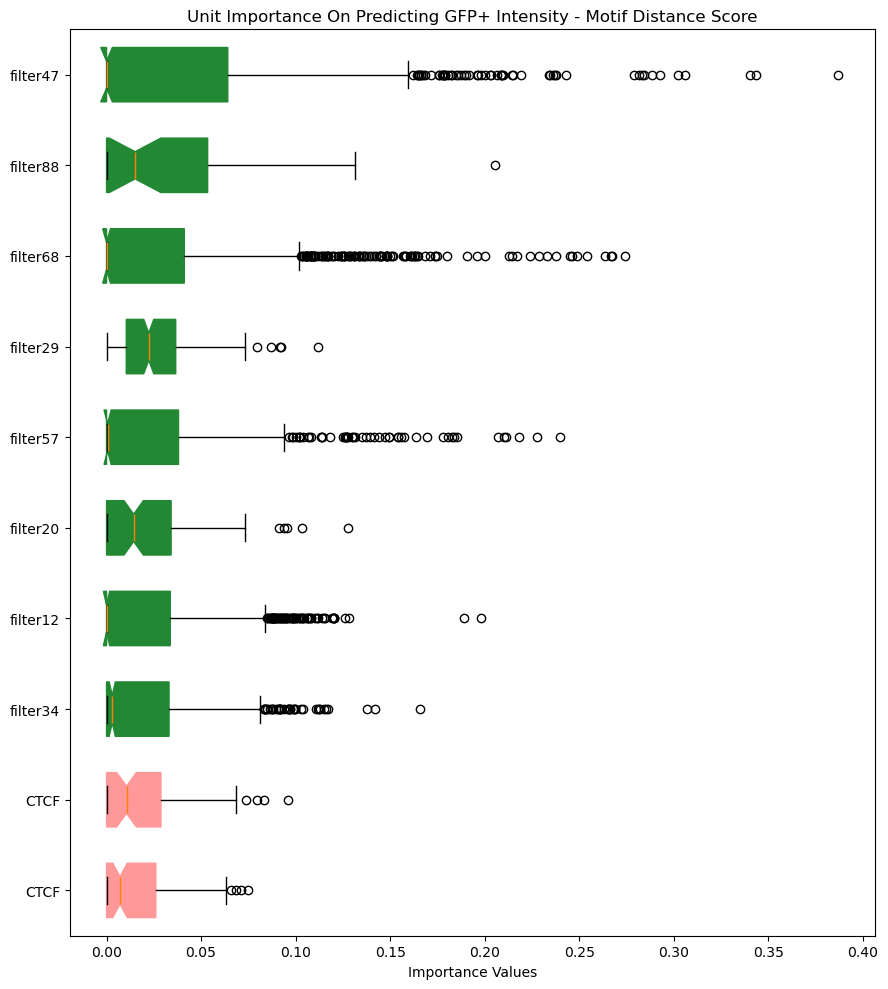

In [25]:
"""Plot the Ranked Importance Value of Each Filter"""
num_filter_plot = 10
# Create a list to store common important filters
common_filters = []

def plot_importance(ax, unit_importance_values, title_suffix):
    # Calculate the means of each list in unit_importance_values
    means = [np.mean(values) for values in unit_importance_values]

    # Create tuples of means, unit names, and values, then sort them by means
    sorted_data = sorted(zip(means, unit_names, unit_filters, unit_importance_values), key=lambda x: x[0], reverse=True)

    # Unzip the sorted data
    sorted_means, sorted_names, sorted_filters, sorted_values = zip(*sorted_data)

    # Print top 10 most impoertant filters
    print(sorted_filters[:num_filter_plot])

    # Unzip the sorted data
    sorted_means, sorted_names, sorted_filters, sorted_values = zip(*sorted_data[:num_filter_plot][::-1])

    # Define properties for outliers (fliers)
    flierprops = dict(marker='o', color='black', markersize=6)

    # Create box plots individually to control colors
    box_width = 0.6  # Set box width
    for i, (name, data) in enumerate(zip(sorted_names, sorted_values)):
        color = "#ff9999" if "filter" not in name.lower() else "#228833"
        ax.boxplot(data, positions=[i + 1], widths=box_width, notch=True, patch_artist=True,vert=False,
                   boxprops=dict(facecolor=color, color=color), flierprops=flierprops)

    # Set custom sorted x-axis labels
    ax.set_yticks(range(1, len(sorted_names) + 1))
    ax.set_yticklabels(sorted_names, rotation=0)
    ax.set_title(f"Unit Importance On Predicting GFP+ Intensity - {title_suffix}")
    ax.set_xlabel("Importance Values")

# Create a single plot
fig, ax = plt.subplots(figsize=(9, 10))

# Plot for Motif Distance Score
plot_importance(ax, unit_importance_motif_dist_score, "Motif Distance Score")

plt.tight_layout()
plt.show()



In [13]:
def get_specific_unit_importance(activations, model, unit_outputs, filt, target_labels):
    """
    Function to compute unit importance (unit_output*class weight) of a particular ExplaiNN unit (indexed at filt)
    :param activations: numpy.array, matrix of activations of shape (N, U, S); N - size of the dataset;
    U - number of units; S - size of the activation map
    :param model: ExplaiNN model
    :param unit_outputs: numpy.array, outputs of individual units, shape (N, U); N - size of the dataset; U - number of units;
    :param filt: int, index of the unit of interest;
    :param target_labels: a list with the names of the output nodes;
    :return: pandas.Series, contains O keys (number of ExplaiNN outputs, labels), each key contains an array of size X,
    where X is equal to the number of sequences that activated the unit of interest (indexed at filt) more than an
    activation threshold
    """

    activation_threshold = 0.5 * np.amax(activations, axis=(0, 2))
    print(f"activation_threshold shape: {activation_threshold.shape}")
    print(f"activation shape: {activations.shape}")

    # sequences (their indeces) that highly activated the filter
    res = {}
    for i in range(activation_threshold.shape[0]):
        if i != filt: continue # focus on current unit
        inds = []
        print(f"current filter is filter{filt}")
        for j in range(activations.shape[0]):
            # For 590 features at jth sample in the ith cnn, find indices of features that are activated 
            indices = np.where(activations[j, i, :] > activation_threshold[i])
            if indices[0].shape[0] > 0:
                inds.append(j)
        res[i] = inds # inds contains index of samples that have at least 1 activated feature among 590 in the specified cnn filter
    

    weights = model.final.weight.detach().cpu().numpy()  # -0.035227 0.480355
    print(f"weights shape {weights.shape}")

    res_distr = {}
    for cl in range(len(target_labels)):
        # 
        f_cell = np.multiply(unit_outputs, weights[cl])
        print(f'For label {target_labels[cl]}')
        print(f'final cell shape after multiplying cnn outputs [sample, num_cnn] with weight [1, num_cnn]: {f_cell.shape}')
        res_distr[target_labels[cl]] = f_cell[:, filt]
        print(f'interested filter final cell shape" {res_distr[target_labels[cl]].shape}')
        print(f'interested filter final cell sum" {np.sum(res_distr[target_labels[cl]])}')
        res_distr[target_labels[cl]] = res_distr[target_labels[cl]][res[filt]]
        print(f'After removing samples dont have any activated features: {res_distr[target_labels[cl]].shape}')

    res_distr = pd.Series(res_distr)

    return res_distr
# unit_outputs are the output 90 feature values for each sample from ExplaiNN linears layer (before final layer) 
unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, explainn, device)
print(unit_outputs.shape)
target_labels = ['Motif Distance Score']
importance = get_specific_unit_importance(activations, explainn, unit_outputs, 55, target_labels)
print(f'importance shape: {importance.shape}')
importance

(2842, 90)
activation_threshold shape: (90,)
activation shape: (2842, 90, 590)
current filter is filter55
weights shape (1, 90)
For label Motif Distance Score
final cell shape after multiplying cnn outputs [sample, num_cnn] with weight [1, num_cnn]: (2842, 90)
interested filter final cell shape" (2842,)
interested filter final cell sum" 13.163741111755371
After removing samples dont have any activated features: (31,)
importance shape: (1,)


Motif Distance Score    [0.0, 0.013689221, 0.001742856, 0.044540904, 0...
dtype: object

filter not annotated
filter not annotated
filter not annotated
filter not annotated
filter not annotated
filter not annotated
filter not annotated
filter not annotated
CTCF
CTCF


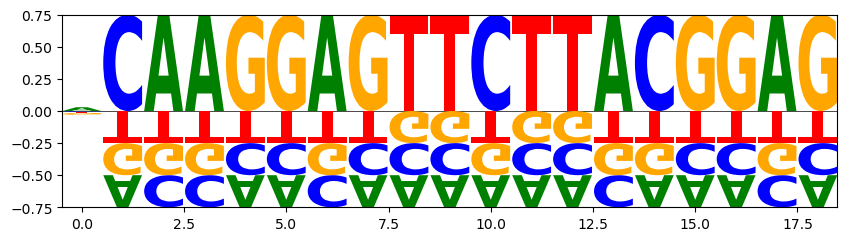

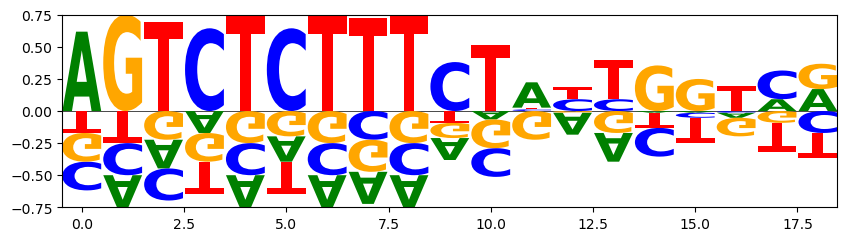

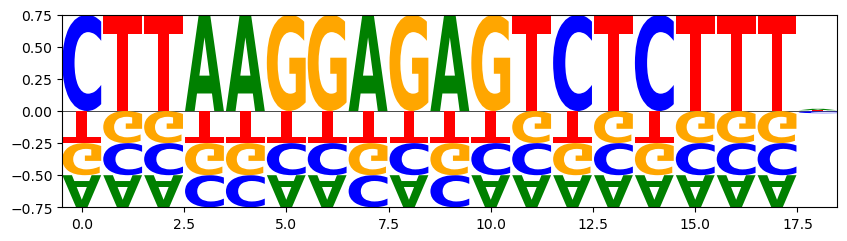

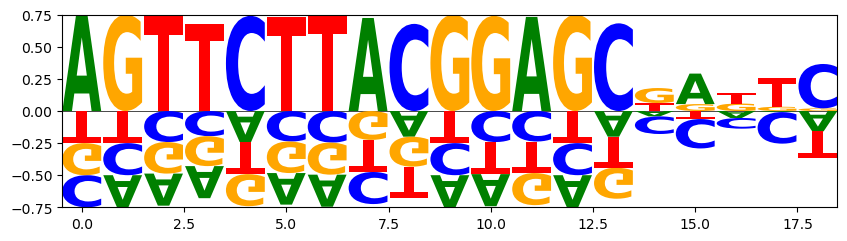

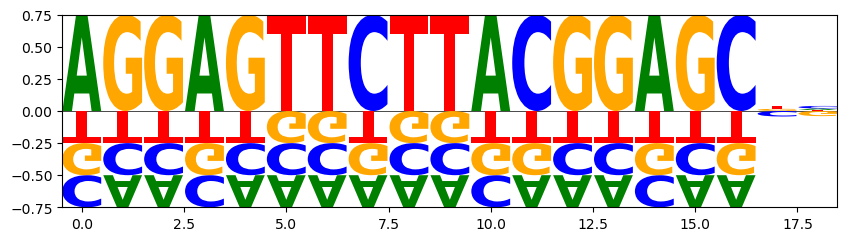

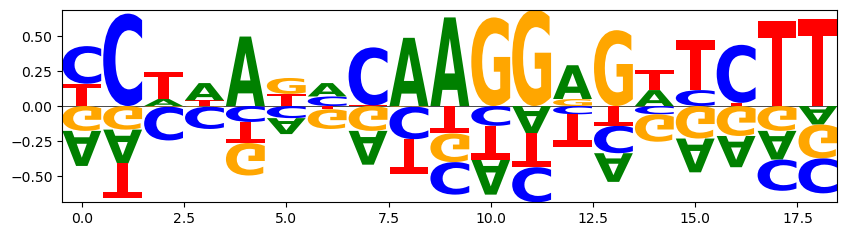

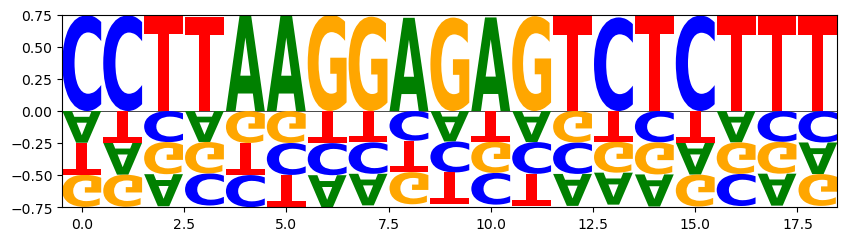

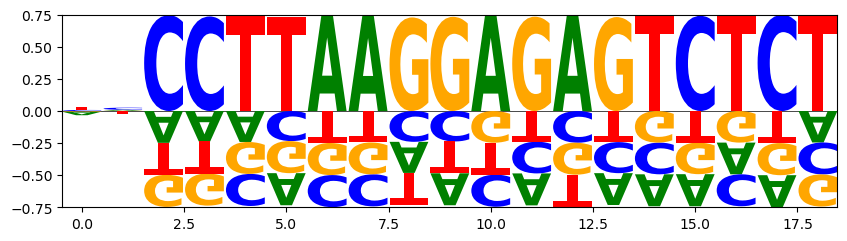

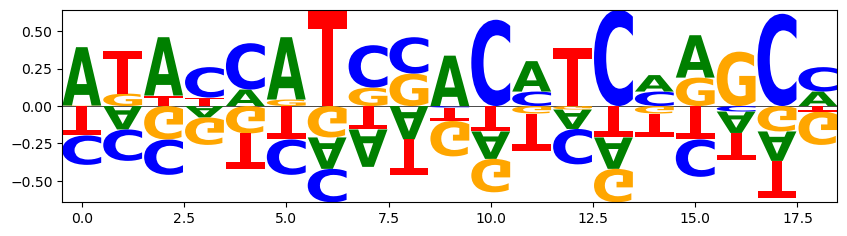

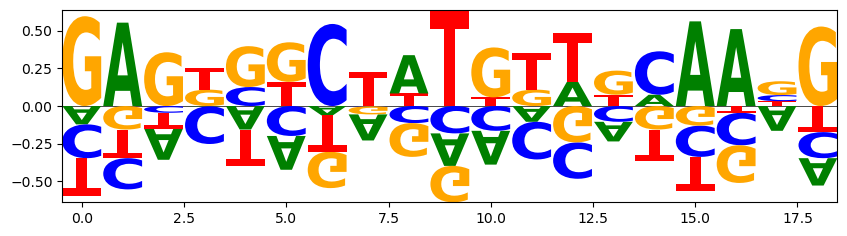

In [26]:
# Generate Motif Logos for top important filter PWMs
motifs, motif_names = tools.read_meme('/pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_synthetic_score_dir_TFBS.meme')

filterid=62
# motifA='CCTTAAGGAGAGTCTCTTT', motifB='CAAGGAGTTCTTACGGAGC'
# For distance score prediction: ('filter47', 'filter88', 'filter68', 'filter29', 'filter57', 'filter20', 'filter12', 'filter34', 'filter19', 'filter21')
for filterid in [47,88,68,29,57,20,12,34,19,21]:
    x = [list(i) for i in motifs[filterid]]
    pwm = tools._PWM_to_filter_weights(x, filter_size)
    nn_logo = logomaker.Logo(pd.DataFrame(data=pwm,columns = ["A","C", "G","T"]))
    if ('filter' + str(filterid)) in annotation:
        print(annotation['filter' + str(filterid)])
    else:
        print("filter not annotated")